<a href="https://colab.research.google.com/github/ohilikeit/Dacon_code_similarity/blob/main/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 로드 및 전처리

## 1) 추가적인 데이터 불러오기
원본 데이터 이외에 추가로 주어진 데이터들을 간단한 전처리를 하면서 불러온다.

In [ ]:
import re 
import os
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
seed = 42
random.seed(seed)
np.random.seed(seed)

folder = '/content/drive/MyDrive/code_similarity/code'
problems = os.listdir(folder)

def preprocess(script):
     with open(script, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            processed_line = []
            for line in lines:
                line = line.rstrip('\n')                  # 각 줄의 오른쪽 '\n'제거 

                if '#' in line:
                    line = line[:line.index('#')]        # 코드 뒤쪽에 달린 주석 제거       
                if line.startswith('#'):
                    continue                              # 주석 삭제 
                line = line.replace('    ','\t')          # '    '를 탭으로 전환 
                line = line.replace('"""','')             # 주석 삭제 
                line = line.replace('?', '')
                line = re.sub(r"[/\?@]","",line )    # 특수문자 제거 
                processed_line.append(line)
            processed_lines = '\n '.join(processed_line)   # '\n'으로 붙이기, 뒤쪽 bm-25 알고리즘이 '\n'은 알아서 가중치 조절할 예정.

     return processed_lines

final_scripts = []
numbers = []
for problem in tqdm(problems):
    scripts = os.listdir(os.path.join(folder, problem))
    number = scripts[0].split('_')[0]

    for script in scripts:
        each_script = os.path.join(folder, problem, script)
        final_script = preprocess(each_script)
        final_scripts.append(final_script)
    numbers.extend([number]*len(scripts))

print(final_scripts)
print(numbers)

In [ ]:
data = pd.DataFrame(data = {'code':final_scripts, 'number': numbers})
data.head()

,code,number
0,\n import sys\n import math\n \n array =[]\n f...,problem003
1,while True :\n \ttry :\n \t\ta = [int(_) for _...,problem003
2,\n \n \n import sys\n \n for line in sys.stdin...,problem003
3,"while True:\n \ttry:\n \t\ta,b=(int(i) for i i...",problem003
4,\n \n def get_input():\n \t\n \twhile True:\n ...,problem003


## 2) 토크나이징
code를 기반으로 pre-train 한 huggingface의 codeberta를 가져와 토크나이징 해준다. 해당 도메인의 corpus로 학습시킨것이 좋다.

In [ ]:
! pip install transformers

In [ ]:
from transformers import AutoTokenizer, RobertaTokenizer
MODEL = "huggingface/CodeBERTa-small-v1"
tokenizer = RobertaTokenizer.from_pretrained(MODEL)

data['tokens'] = data['code'].apply(tokenizer.tokenize)
data['len'] = data['tokens'].apply(len)
data.describe()

,len
count,45101.000000
mean,158.847099
std,388.523850
min,5.000000
25%,62.000000
50%,109.000000
75%,199.000000
max,71795.000000


## 3) 길이 조절하기
 input으로 code1과 code2를 동시에 받기에 토큰의 최대 사이즈 512를 고려하여 300을 넘기는 code들을 버린다. 512개까지의 토큰을 가져와서 모델을 돌리면 512 + 512 = 1024개의 토큰 중 절반이 truncation 된다.
 이보단 모든 조합이 가능하면 온전하게 학습되길 원했던 점 + 시간과 자원이 부족한점의 trade-off가 300개 이하의 토큰이였다.

In [ ]:
df = data[data['len'] <= 300].reset_index(drop=True) 
df

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


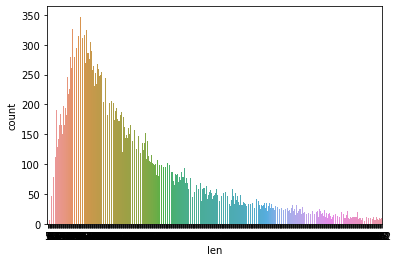

In [ ]:
# 토큰의 길이의 갯수에 대한 분포이다. 
import seaborn as sns
sns.countplot(df['len'])

## 4) train, val 구성
train pair 셋 안에 val의 pair의 데이터가 들어가면 악영향을 줄 수 있기에 미리 분리해서 pair를 만든다. 

In [ ]:
from sklearn.model_selection import train_test_split

train_df, val_df, train_y, val_y = train_test_split(df, df['number'],
                                                    random_state=42,
                                                    test_size=0.2,
                                                    stratify=df['number'])
train_df.reset_index(drop = True, inplace = True)
val_df.reset_index(drop = True, inplace=True)

In [ ]:
train_df.to_csv('/content/drive/MyDrive/code_similarity/train_df.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/code_similarity/val_df.csv', index=False)

# 2. pair 구성하기
bm25 알고리즘을 활용하여 각 코드파일마다 25개 미만의 가장 가까우면서도 서로 다른 negative pair를 구성하여 모델을 robust하게 만들어주길 기도하겠다. positive pair의 경우 combination을 사용하였다.

In [ ]:
! pip install rank_bm25
! pip install transformers

from numba import jit
! @jit(nopython=True, cache=True)

In [ ]:
import re 
import os
import pandas as pd
import numpy as np
seed = 42
random.seed(seed)
np.random.seed(seed)
from tqdm import tqdm
from rank_bm25 import BM25Okapi
from itertools import combinations
from tqdm import tqdm
from transformers import AutoTokenizer, RobertaTokenizer

train_df = pd.read_csv('/content/drive/MyDrive/code_similarity/train_df.csv')
val_df = pd.read_csv('/content/drive/MyDrive/code_similarity/val_df.csv')

# 토크나이저 불러오기
MODEL = "huggingface/CodeBERTa-small-v1"
tokenizer = RobertaTokenizer.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/971k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/471k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

## 1) train set pair 구성

In [ ]:
codes = train_df['code'].to_list()
problem_num = train_df['number'].unique().tolist()
problem_num.sort()

# bm25 알고리즘 
tokenized_corpus = [tokenizer.tokenize(code) for code in codes]
bm25 = BM25Okapi(tokenized_corpus)

# pair 구성
# problem number 하나 당 4~5분 걸리고 전체 number가 300이므로 20~25시간이 걸린다.
final_positive_pairs = []
final_negative_pairs = []

test = []
for num in tqdm(problem_num): 
    working_codes = train_df[train_df['number'] == num]['code']
    positive_pairs = list(combinations(working_codes, 2))  # combination으로 전부 고려 
    negative_pairs = []

    for working_code in tqdm(working_codes):
        negative_ones = []
        bm50 = np.array(bm25.get_top_n(working_code, codes, 50)) # score 기반으로 top50 개 추출
        negative_ones = [bm50[i] for i in range(50) if bm50[i] not in working_codes] # ㅋtop50 
        
        for negative_one in negative_ones:
             negative_pairs.append((working_code, negative_one)) 
        # top50 중에 돌아가고 있는 problem codes들과 겹치지 않는 것만 append  

    final_positive_pairs.extend(positive_pairs)
    final_negative_pairs.extend(negative_pairs)

pos_code1 = list(map(lambda x:x[0], final_positive_pairs))
pos_code2 = list(map(lambda x:x[1], final_positive_pairs))
pos_label = [1]*len(pos_code1)

neg_code1 = list(map(lambda x:x[0], final_negative_pairs))
neg_code2 = list(map(lambda x:x[1], final_negative_pairs))
neg_label = [0]*len(neg_code1)

pos_code1.extend(neg_code1)
pos_code2.extend(neg_code2)
pos_label.extend(neg_label)

full_data = pd.DataFrame({
    'code1' : pos_code1,
    'code2' : pos_code2,
    'similar' : pos_label
})
full_data = full_data.sample(frac=1, random_state=42).reset_index(drop=True) 
full_data.to_csv('/content/drive/MyDrive/code_similarity/train_data', index=False)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
100%|██████████| 110/110 [9:54:53<00:00, 324.48s/it]


In [ ]:
'''
import pickle
with open('/content/drive/MyDrive/code_similarity/final_positive_pairs_80_190.pkl', 'wb') as f:
    pickle.dump(final_positive_pairs, f)
with open('/content/drive/MyDrive/code_similarity/final_negative_pairs_80_190.pkl', 'wb') as f:
    pickle.dump(final_negative_pairs, f)

with open('/content/drive/MyDrive/code_similarity/final_positive_pairs_80_190.pkl', 'rb') as f:
    final_positive_pairs_80_190 = pickle.load(f)
with open('/content/drive/MyDrive/code_similarity/final_negative_pairs_80_190.pkl', 'rb') as f:
    final_negative_pairs_80_190 = pickle.load(f)

print(len(final_positive_pairs))
print(len(final_negative_pairs))
print(len(final_positive_pairs_80_190))
print(len(final_negative_pairs_80_190))
'''

In [ ]:
train_data1 = pd.read_csv('/content/drive/MyDrive/code_similarity/train_data_1')
train_data2 = pd.read_csv('/content/drive/MyDrive/code_similarity/train_data_2')
train_data3 = pd.read_csv('/content/drive/MyDrive/code_similarity/train_data_3')
sample_train = pd.read_csv('/content/drive/MyDrive/code_similarity/sample_train.csv')

def preprocess(lines):
    cleaned_lines = []
    for line in lines:
        line = line.rstrip('\n')
        
        line = line.replace('    ','\t')          # '    '를 탭으로 전환 
        line = line.replace('"""','')             # 주석 삭제 
        line = line.replace('?', '')
        line = re.sub(r"[^a-zA-Z0-9|^\-=+*?|^.<>!%^(){}[]]","",line)

        cleaned_lines.append(line)

    return cleaned_lines

code1 = preprocess(sample_train['code1'])
code2 = preprocess(sample_train['code2'])

sample_train['code1'] = code1
sample_train['code2'] = code2

train_data = pd.concat([train_data1, train_data2, train_data3, sample_train], ignore_index = True)
train_data.to_csv('/content/drive/MyDrive/code_similarity/train_data')

,code1,code2,similar
0,"s = raw_input().rstrip().split("" "")\n a = int(...","a,b,c=(int(i) for i in input().split())\n \n i...",1
1,"f = open(0)\n N, M, L = map(int, f.readline()....","n,m,l=map(int,input().split())\n a = [[0 for i...",1
2,from collections import deque\n que = deque()\...,from collections import deque\n \n areas = inp...,1
3,S = input()\n print('{}s'.format(S)) if S[-1] ...,if __name__ == '__main__':\n \ttry:\n \t\ts = ...,1
4,print input()^1,"n=list(map(int,input().split()))\n p=['2354','...",0
...,...,...,...
3365888,"import math\nA, B, H, M = map(int, input().spl...","d,t,s = input().split()\n\nif(int(s) * int(t) ...",0
3365889,"n = int(input())\ns, t = input().split()\n\nan...","H,W,N=[int(input()) for i in range(3)]\nprint(...",0
3365890,"H,W,k = map(int, input().split())\n# アイテムが何処に何...",from numba import jit\nimport numpy as np\n@ji...,1
3365891,#E\nimport math\nn = int(input())\nans = 0\ni ...,#!/usr/bin/env python\n# coding: utf-8\n\n# In...,1


## 2) valid set pair 구성
validation 셋으로 너무 많은 데이터를 사용할 수 없으므로 posivite pair 107,399 개와 problems(299) X 각 problem 당 코드 평균 갯수(30) X 각 12개(12) = 107,640 개를 합쳐 총 202,391 개의 validation 셋을 생성하였다. 추후 학습시간에 따라 층화추출하여 적절히 활용하면 된다. 대회에서 제공되는 기본 데이터셋은 모두 train셋으로 이용하겠다.

In [ ]:
codes = val_df['code'].to_list()
problem_num = val_df['number'].unique().tolist()
problem_num.sort()

# bm25 알고리즘 
tokenized_corpus = [tokenizer.tokenize(code) for code in codes]
bm25 = BM25Okapi(tokenized_corpus)

# pair 구성
final_positive_pairs = []
final_negative_pairs = []


test = []
for num in tqdm(problem_num):  
    working_codes = val_df[val_df['number'] == num]['code']
    positive_pairs = list(combinations(working_codes, 2))  # combination으로 전부 고려 
    negative_pairs = []

    for working_code in tqdm(working_codes):
        negative_ones = []
        bm10 = np.array(bm25.get_top_n(working_code, codes, 12)) # score 기반으로 top12개 추출
        '''
        for i in range(100):
            idx = bm100[i]
            if idx not in working_codes:
                negative_ones.append(idx)
        '''
        negative_ones = [bm10[i] for i in range(12) if bm10[i] not in working_codes] 
        
        for negative_one in negative_ones:
             negative_pairs.append((working_code, negative_one)) 
        # top3 중에 돌아가고 있는 problem codes들과 겹치지 않는 것만 append  

    final_positive_pairs.extend(positive_pairs)
    final_negative_pairs.extend(negative_pairs)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
100%|██████████| 299/299 [1:12:02<00:00, 14.46s/it]


In [ ]:
pos_code1 = list(map(lambda x:x[0], final_positive_pairs))
pos_code2 = list(map(lambda x:x[1], final_positive_pairs))
pos_label = [1]*len(pos_code1)

neg_code1 = list(map(lambda x:x[0], final_negative_pairs))
neg_code2 = list(map(lambda x:x[1], final_negative_pairs))
neg_label = [0]*len(neg_code1)

pos_code1.extend(neg_code1)
pos_code2.extend(neg_code2)
pos_label.extend(neg_label)

val_data = pd.DataFrame({
    'code1' : pos_code1,
    'code2' : pos_code2,
    'similar' : pos_label
})
val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)
val_data
val_data.to_csv('/content/drive/MyDrive/code_similarity/val_data', index=False)

,code1,code2,similar
0,N = int(input())\n R = [int(input()) for _ in ...,"n,m=map(int,input().split())\n g=[[] for i in ...",0
1,"import math\n n = float(input())\n area = ""%.6...","import math\n r = input()\n print(""%f %f"" % (m...",1
2,"print 'win' if sum(map(int, raw_input().split(...","A1,A2,A3=map(int, input().split())\n print('wi...",1
3,"taro, hanako = 0, 0\n n = int(input())\n for _...","f=lambda:[*map(int,input().split())]\n n,k=f()...",0
4,"n = int(input())\n num_list = list(map(int, in...","n=int(input())\n \n abc = ['a','b','c','d','e'...",0
...,...,...,...
202386,import sys\n \n i = 1\n \n while(1):\n \ta = r...,"s={""a"":""b"",""b"":""c"",""c"":""d"",""d"":""e"",""e"":""f"",""f""...",0
202387,"N, K = map(int, input().split())\n A = sorted(...","n, k = map(int, input().split())\n a = list(ma...",1
202388,"a,b,c,d = map(int,input().split(' '))\n matrix...","n,k=map(int,input().split())\n r,s,p=map(int,i...",0
202389,"def main():\n \tx_tuple = tuple(map(int, input...","s={""a"":""b"",""b"":""c"",""c"":""d"",""d"":""e"",""e"":""f"",""f""...",0
